# TD NLP Correction

L’analyse de sentiments est une technique qui s’est fortement développée en même temps que les réseaux sociaux, où les utilisateurs ont la possibilité de s’exprimer massivement et de partager en permanence leurs sentiments. L’analyse de sentiment (ou sentiment analysis en anglais) vise donc à déterminer la tonalité émotionnelle d’un discours en le classifiant dans différentes catégories comme positif, négatif ou neutre par exemple.
Le but de cet exercice est de faire de l'analyse de sentiment sur des commentaires de réseaux sociaux labélisés (insultant/normal) dans le but de faire de la modération automatique par exemple. 


Télécharger le fichier _toxic_comment.csv_

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#### Charger les commentaires dans un dataframe pandas.

In [2]:
data = pd.read_csv('toxic_comment.csv')
data

,comment_text,toxic
0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
1,Hey... what is it..\n@ | talk .\nWhat is it......,1
2,"Bye! \n\nDon't look, come or think of comming ...",1
3,You are gay or antisemmitian? \n\nArchangel WH...,1
4,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...
30789,"""\n\nYou raise a lot of interesting issues. I'...",0
30790,"If Christianity is so good, how come they have...",0
30791,"Good job, Gudzwabofer! You really proved the M...",0
30792,Jayjg and I are not lovers. No matter what ki...,0


Afficher deux critiques positives et deux critiques négatives. Le texte a t-il besoin de prétraitrement ? Lesquels. 

In [3]:
toxic_com = data.loc[(data['toxic']==1)]
for com in toxic_com['comment_text'][0:3]:
    print(com + '\n')


COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...

Bye! 

Don't look, come or think of comming back! Tosser.



In [4]:
nontoxic_com = data.loc[(data['toxic']==0)]
for com in nontoxic_com['comment_text'][0:3]:
    print(com + '\n')

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.



#### Nettoyage des commentaires : 
- enlever la ponctuaction et les caractères spéciaux
- enlever les stopwords
- lemmatisation

Importer spacy et charger le modèle de langue anglaise

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

Créer une fonction permettant de nettoyer le texte

In [7]:
def treat_comment(comment):
    
    my_stopwords = list(nlp.Defaults.stop_words)
    for word in ['wikipedia', 'article', 'page']:
        my_stopwords.append(word)
        
    comment = comment.lower()
    
    spacy_comment = nlp(comment, disable=["parser", "ner", "textcat"])
    spacy_tokens = [w.lemma_ for w in spacy_comment if w.is_alpha and not w.is_stop]
    
    treated_tokens = [w for w in spacy_tokens if w not in my_stopwords]

    return " ".join(treated_tokens)

Appliquer le nettoyage sur l'ensemble des commentaires du dataframe. Cette étape prend un peu (beaucoup) de temps, c'est normal!

In [8]:
clean_data = data.copy()
clean_data['clean_text'] = clean_data['comment_text'].apply(treat_comment)

In [9]:
clean_toxic_com = clean_data.loc[(clean_data['toxic']==1)]
for com in clean_toxic_com['clean_text'][0:3]:
    print(com + '\n')

cocksucker piss work

hey talk exclusive group wp taliban good destroy self appoint purist gang ask question abt anti social destructive wp ask sityush clean behavior issue nonsensical warning

bye look come think comme tosser



In [10]:
clean_nontoxic_com = clean_data.loc[(clean_data['toxic']==0)]
for com in clean_nontoxic_com['clean_text'][0:3]:
    print(com + '\n')

explanation edit username hardcore metallica fan revert vandalism closure gas vote new york dolls fac remove template talk retire

match background colour seemingly stick thank talk january utc

hey man try edit war guy constantly remove relevant information talk edit instead talk care formatting actual info



In [11]:
clean_data.groupby('toxic').count()

,comment_text,clean_text
toxic,,
0,15500,15500
1,15294,15294


Text(0, 0.5, 'Occurences')

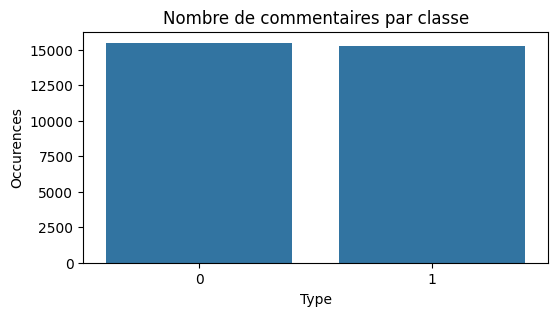

In [12]:
x = clean_data.groupby('toxic').count().reset_index()
#plot
plt.figure(figsize=(6,3))
ax= sns.barplot(x, x="toxic", y="clean_text")
plt.title("Nombre de commentaires par classe")
plt.xlabel('Type')
plt.ylabel('Occurences')

#### Analyse des commentaires
- Afficher des nuage de mots pour les commentaires positifs et négatifs.

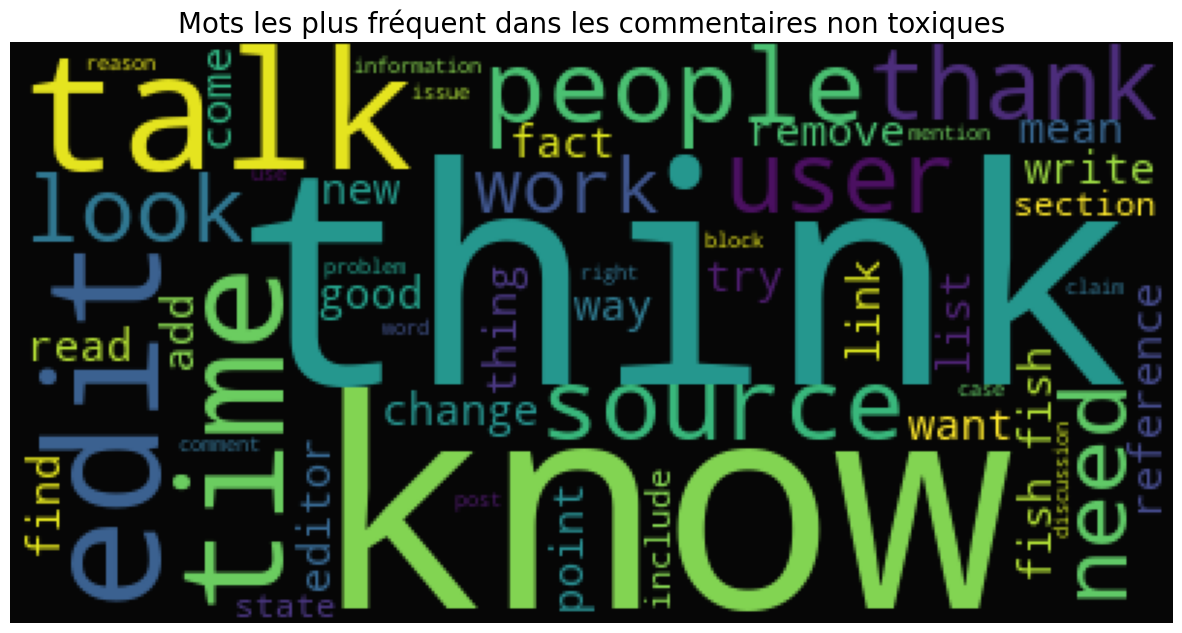

In [13]:
subset=clean_data[clean_data.toxic==0]
text=subset.clean_text.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires non toxiques", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

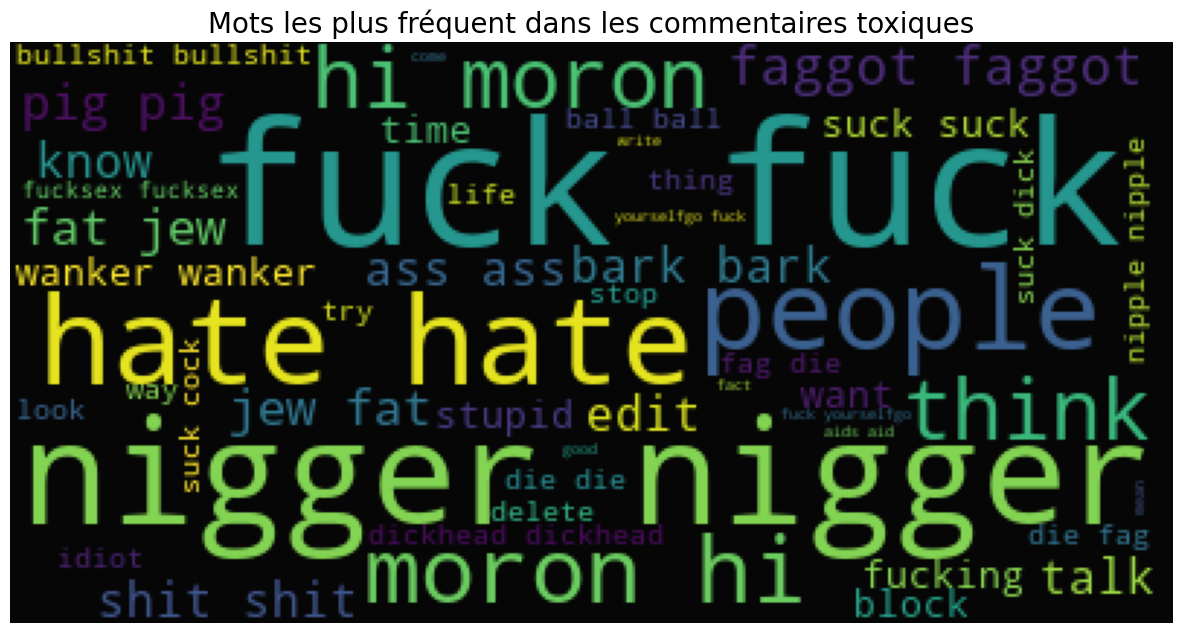

In [14]:
subset=clean_data[clean_data.toxic==1]
text=subset.clean_text.values
wc= WordCloud(background_color="black",max_words=50)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Mots les plus fréquent dans les commentaires toxiques", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

#### Vectorisation des commentaires : 
Transformer les commentaires en vecteurs numériques admissible par un algorithme de machine learning.
On va utiliser le vectoriseur Tf-Idf (cf glossaire NLP)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(clean_data['clean_text'])

#### Analyse des commentaires vectorisés
- Afficher des graphiques en barre montarant les 10 mots ayant le plus de poids dans les commentaires positifs et négatifs.

In [17]:
vocab_col = list(vectorizer.get_feature_names_out())
tfidf_data = X.toarray()

In [18]:
df_poids = pd.DataFrame(tfidf_data, columns=vocab_col)
df_poids['label'] = clean_data['toxic']
df_poids

,ability,able,absolute,absolutely,abuse,abusive,academic,accept,acceptable,access,...,yes,yo,yooo,york,youbollock,young,yourselfgo,youtube,zero,zionist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_viz = df_poids.groupby('label').sum()
df_viz = df_viz.transpose().reset_index()
df_viz = df_viz.rename(columns={'index':'vocab', 0:'poids_nontoxic', 1:'poids_toxic'})
df_viz

label,vocab,poids_nontoxic,poids_toxic
0,ability,13.065898,8.037440
1,able,42.832618,16.838147
2,absolute,5.950056,11.622691
3,absolutely,19.635336,19.826890
4,abuse,26.689298,39.261613
...,...,...,...
1994,young,15.404977,10.445687
1995,yourselfgo,0.000000,1.895063
1996,youtube,11.413623,6.247088
1997,zero,12.424082,10.699531


In [20]:
top10_toxic = df_viz[['vocab', 'poids_toxic']].sort_values(by=['poids_toxic'],ascending=False).head(10)
top10_toxic

label,vocab,poids_toxic
747,fuck,876.922825
751,fucking,453.803356
1052,like,388.279685
1625,shit,354.998247
1750,suck,338.606847
1727,stop,281.696478
205,block,276.465274
195,bitch,273.892676
1742,stupid,270.438456
1008,know,263.775375


<Axes: xlabel='vocab', ylabel='poids_toxic'>

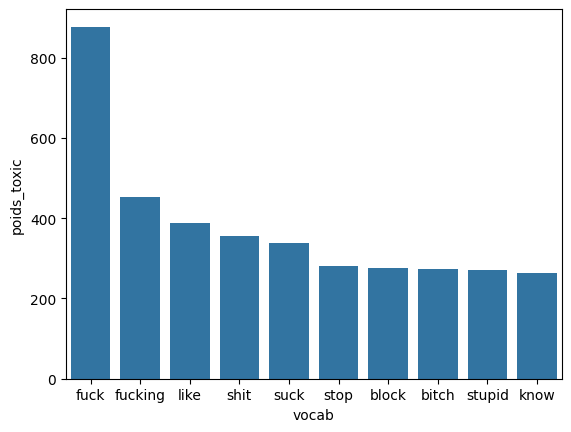

In [21]:
sns.barplot(top10_toxic, x="vocab", y="poids_toxic")

In [22]:
top10_nontoxic = df_viz[['vocab', 'poids_nontoxic']].sort_values(by=['poids_nontoxic'],ascending=False).head(10)
top10_nontoxic

label,vocab,poids_nontoxic
1778,talk,517.301570
574,edit,437.882039
1796,thank,426.406056
1683,source,286.889645
1799,think,279.904663
1008,know,271.575652
1052,like,267.671892
26,add,254.303840
205,block,241.062552
786,good,239.986948


<Axes: xlabel='vocab', ylabel='poids_nontoxic'>

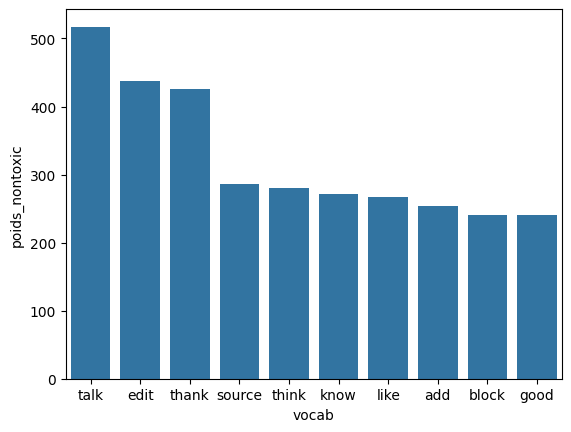

In [23]:
sns.barplot(top10_nontoxic, x="vocab", y="poids_nontoxic")

#### Séparation des données train et test pour entraînement

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = X.toarray()

In [29]:
y = clean_data.toxic.values

In [33]:
y.shape

(30794,)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [36]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23095, 2000)
(23095,)
(7699, 2000)
(7699,)


### Classification Machine Learning
Faire une regression logistique pour classer les revues positives et négatives. Evaluer votre modèle sur le test

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [40]:
# Score du modèle sur les données d'entraînement
model.score(X_train, y_train)

0.9081186403983547

##### Evaluation du modèle

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [42]:
y_pred = model.predict(X_test)

In [43]:
accuracy_score(y_test, y_pred)

0.8898558254318742

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      3833
           1       0.92      0.86      0.89      3866

    accuracy                           0.89      7699
   macro avg       0.89      0.89      0.89      7699
weighted avg       0.89      0.89      0.89      7699



In [45]:
confusion_matrix(y_test, y_pred)

array([[3537,  296],
       [ 552, 3314]], dtype=int64)